## Imports

In [1]:
!python -V

Python 3.10.16


In [1]:
import pickle
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error

# Class

## Read data

In [7]:
!wget "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"

--2025-05-12 10:02:32--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.163, 18.239.38.83, 18.239.38.147, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1333519 (1.3M) [binary/octet-stream]
Saving to: ‘green_tripdata_2021-01.parquet’

green_tripdata_2021 100%[===================>]   1.27M  --.-KB/s    in 0.01s   

2025-05-12 10:02:32 (98.0 MB/s) - ‘green_tripdata_2021-01.parquet’ saved [1333519/1333519]



In [10]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

## Train LinReg

In [13]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829626

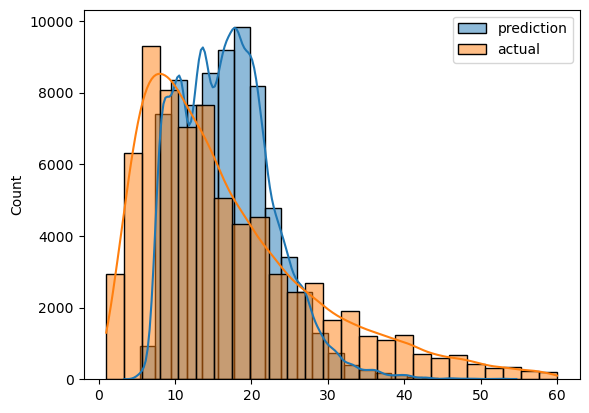

In [17]:
sns.histplot(y_pred, bins=25, label='prediction', kde=True)
sns.histplot(y_train, bins=25, label='actual', kde=True)

plt.legend()
plt.show()

## Validate LinReg

In [18]:
!wget "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"

--2025-05-12 10:11:29--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.163, 18.239.38.83, 18.239.38.147, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145679 (1.1M) [binary/octet-stream]
Saving to: ‘green_tripdata_2021-02.parquet’

green_tripdata_2021 100%[===================>]   1.09M  --.-KB/s    in 0.006s  

2025-05-12 10:11:29 (193 MB/s) - ‘green_tripdata_2021-02.parquet’ saved [1145679/1145679]



In [19]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [21]:
df_train.shape, df_val.shape

((73908, 21), (61921, 21))

Pre-process train and val datasets

In [22]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

Train model (again)

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715204657856

Save model

In [ ]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728

# Homework

## Read data

In [26]:
!wget "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
!wget "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"

--2025-05-12 10:17:41--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.147, 18.239.38.181, 18.239.38.163, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M  --.-KB/s    in 0.1s    

2025-05-12 10:17:41 (429 MB/s) - ‘yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]

--2025-05-12 10:17:41--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.239.38.181, 18.239.38.147, 18.239.38.83, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.239.38.181|:443... connected

In [3]:
df = pd.read_parquet('yellow_tripdata_2023-01.parquet')
print(df.shape)
df.head()

(3066766, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.std()

42.594351241920904

In [5]:
df_filtered = df[(df.duration >= 1) & (df.duration <= 60)]

round(len(df_filtered) * 100.0 / len(df), 2)

98.12

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_filtered[categorical] = df_filtered[categorical].astype(str)
train_dicts = df_filtered[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(X_train.shape)

target = 'duration'
y_train = df_filtered[target].values

/tmp/ipykernel_57876/2299541947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[categorical] = df_filtered[categorical].astype(str)


(3009173, 516)


In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.658390530899328

In [8]:
df_val = pd.read_parquet('yellow_tripdata_2023-02.parquet')
df_val['duration'] = df_val.tpep_dropoff_datetime - df_val.tpep_pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)
df_val = df_val.query("1 <= duration <= 60")

df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

In [9]:
y_val_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_val_pred)

12.509538246477355